# Description

### 데이터셋 설명
- 2010년 12월부터 2012년 11월까지 68,176건의 온라인 세일즈 데이터 

### 데이터 분석 목표
- 코호트 분석을 통해 '코호트 그룹간 retention rate의 유의미한 차이점이 존재한다'는 가설 검증
    * 가설이 참일 경우 : 코호트 그룹간의 retention rate 차이를 만드는 요소 파악 진행
    * 가설이 거짓일 경우 : 코호트 분석 결과를 바탕으로, 사용자 인사이트 파악을 위한 추가 데이터 분석 방향 설정

# 데이터 전처리

In [5]:
# 패키지 불러오기
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [6]:
# 데이터 크기 확인 및 훑어보기
data = pd.read_csv('/Users/michael/Desktop/practice/online12M.csv')
print(data.shape)
data.head()

(68176, 9)


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


In [7]:
# 정량 변수 통계 요약 확인
data.describe()

,Unnamed: 0,InvoiceNo,Quantity,UnitPrice,CustomerID
count,68176.000000,68176.000000,68176.000000,68176.000000,68176.000000
mean,289370.657475,561562.235904,11.556119,3.069209,15544.700100
std,146889.736960,12570.817828,41.133000,32.513232,1593.010549
min,22523.000000,538172.000000,1.000000,0.001000,12747.000000
25%,162577.500000,550512.000000,2.000000,1.250000,14189.000000
50%,295236.500000,562779.000000,4.000000,1.850000,15513.000000
75%,417174.500000,572650.000000,12.000000,3.750000,16930.000000
max,541893.000000,581586.000000,4300.000000,8142.750000,18287.000000


In [8]:
# 변수 별 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68176 entries, 0 to 68175
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   68176 non-null  int64  
 1   InvoiceNo    68176 non-null  int64  
 2   StockCode    68176 non-null  object 
 3   Description  68176 non-null  object 
 4   Quantity     68176 non-null  int64  
 5   InvoiceDate  68176 non-null  object 
 6   UnitPrice    68176 non-null  float64
 7   CustomerID   68176 non-null  int64  
 8   Country      68176 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 4.7+ MB


# 코호트 분석

In [12]:
# 구매 번호(InvoiceNo)별로 구매월(Invoice month : 해당 구매 건 연월)과 and 코호트 월(Cohort month : 해당 구매 고객이 처음 구매한 연월) 
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceMonth'] = data['InvoiceDate'].dt.strftime('%Y-%m-01')
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceMonth'].transform('min')
data.tail()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
68171,126250,547069,22907,PACK OF 20 NAPKINS PANTRY DESIGN,1,2011-03-20,0.85,16710,United Kingdom,2011-03-01,2010-12-01
68172,448575,575063,22804,PINK HANGING HEART T-LIGHT HOLDER,1,2011-11-08,2.95,16764,United Kingdom,2011-11-01,2011-07-01
68173,264154,560089,23238,SET OF 4 KNICK KNACK TINS LONDON,1,2011-07-14,4.15,12748,United Kingdom,2011-07-01,2010-12-01
68174,199822,554103,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2,2011-05-22,2.95,15555,United Kingdom,2011-05-01,2010-12-01
68175,312243,564342,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,2,2011-08-24,2.95,16340,United Kingdom,2011-08-01,2011-08-01


In [13]:
# 구매월(Invoice month)과 and 코호트 월(Cohort month) 날짜 데이터로 변환
data['InvoiceMonth'] = pd.to_datetime(data['InvoiceMonth'])
data['CohortMonth'] = pd.to_datetime(data['CohortMonth'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68176 entries, 0 to 68175
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    68176 non-null  int64         
 1   InvoiceNo     68176 non-null  int64         
 2   StockCode     68176 non-null  object        
 3   Description   68176 non-null  object        
 4   Quantity      68176 non-null  int64         
 5   InvoiceDate   68176 non-null  datetime64[ns]
 6   UnitPrice     68176 non-null  float64       
 7   CustomerID    68176 non-null  int64         
 8   Country       68176 non-null  object        
 9   InvoiceMonth  68176 non-null  datetime64[ns]
 10  CohortMonth   68176 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(4), object(3)
memory usage: 5.7+ MB


In [14]:
# 코호트 인덱스(구매 건 별로 코호트 월(Cohort month)과 구매월(Invoice month)의 차이) 계산
def cohortindex(date1, date2) : 
    result = (date1.dt.year - date2.dt.year)*12 + (date1.dt.month - date2.dt.month)+1
    return result

data['CohortIndex'] = cohortindex(data['InvoiceMonth'], data['CohortMonth'])
data.tail()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
68171,126250,547069,22907,PACK OF 20 NAPKINS PANTRY DESIGN,1,2011-03-20,0.85,16710,United Kingdom,2011-03-01,2010-12-01,4
68172,448575,575063,22804,PINK HANGING HEART T-LIGHT HOLDER,1,2011-11-08,2.95,16764,United Kingdom,2011-11-01,2011-07-01,5
68173,264154,560089,23238,SET OF 4 KNICK KNACK TINS LONDON,1,2011-07-14,4.15,12748,United Kingdom,2011-07-01,2010-12-01,8
68174,199822,554103,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2,2011-05-22,2.95,15555,United Kingdom,2011-05-01,2010-12-01,6
68175,312243,564342,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,2,2011-08-24,2.95,16340,United Kingdom,2011-08-01,2011-08-01,1


# 코호트 분석 결과 확인

In [15]:
# 코호트 매트릭스(Cohort matrix : 코호트 그룹 별로 시간 흐름(월)에 따른 구매 고객 수) 계산
grouping = data.groupby(['CohortMonth', 'CohortIndex']).agg({'CustomerID' : 'nunique'})
pivoting = grouping.pivot_table(values = 'CustomerID', index = 'CohortMonth', columns = 'CohortIndex', aggfunc = 'sum')
pivoting

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,383.0,149.0,145.0,156.0,165.0,180.0,160.0,147.0,154.0,160.0,150.0,208.0,113.0
2011-01-01,429.0,109.0,134.0,123.0,161.0,139.0,126.0,130.0,160.0,146.0,180.0,77.0,NaN
2011-02-01,352.0,67.0,67.0,94.0,97.0,85.0,91.0,98.0,100.0,113.0,36.0,NaN,NaN
2011-03-01,422.0,67.0,113.0,88.0,91.0,74.0,113.0,94.0,122.0,44.0,NaN,NaN,NaN
2011-04-01,279.0,61.0,60.0,59.0,58.0,59.0,67.0,70.0,18.0,NaN,NaN,NaN,NaN
2011-05-01,267.0,41.0,47.0,41.0,55.0,62.0,68.0,25.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,33.0,27.0,43.0,49.0,64.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,185.0,29.0,33.0,42.0,47.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,145.0,30.0,30.0,36.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# 코호트 별 Retention Rate 계산
cohort_size = pivoting.iloc[:,0]
retention_rate = pivoting.divide(cohort_size, axis = 0)
retention_rate

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.389034,0.378590,0.407311,0.430809,0.469974,0.417755,0.383812,0.402089,0.417755,0.391645,0.543081,0.295039
2011-01-01,1.0,0.254079,0.312354,0.286713,0.375291,0.324009,0.293706,0.303030,0.372960,0.340326,0.419580,0.179487,NaN
2011-02-01,1.0,0.190341,0.190341,0.267045,0.275568,0.241477,0.258523,0.278409,0.284091,0.321023,0.102273,NaN,NaN
2011-03-01,1.0,0.158768,0.267773,0.208531,0.215640,0.175355,0.267773,0.222749,0.289100,0.104265,NaN,NaN,NaN
2011-04-01,1.0,0.218638,0.215054,0.211470,0.207885,0.211470,0.240143,0.250896,0.064516,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.153558,0.176030,0.153558,0.205993,0.232210,0.254682,0.093633,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.154206,0.126168,0.200935,0.228972,0.299065,0.088785,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.156757,0.178378,0.227027,0.254054,0.102703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.206897,0.206897,0.248276,0.103448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='CohortMonth'>

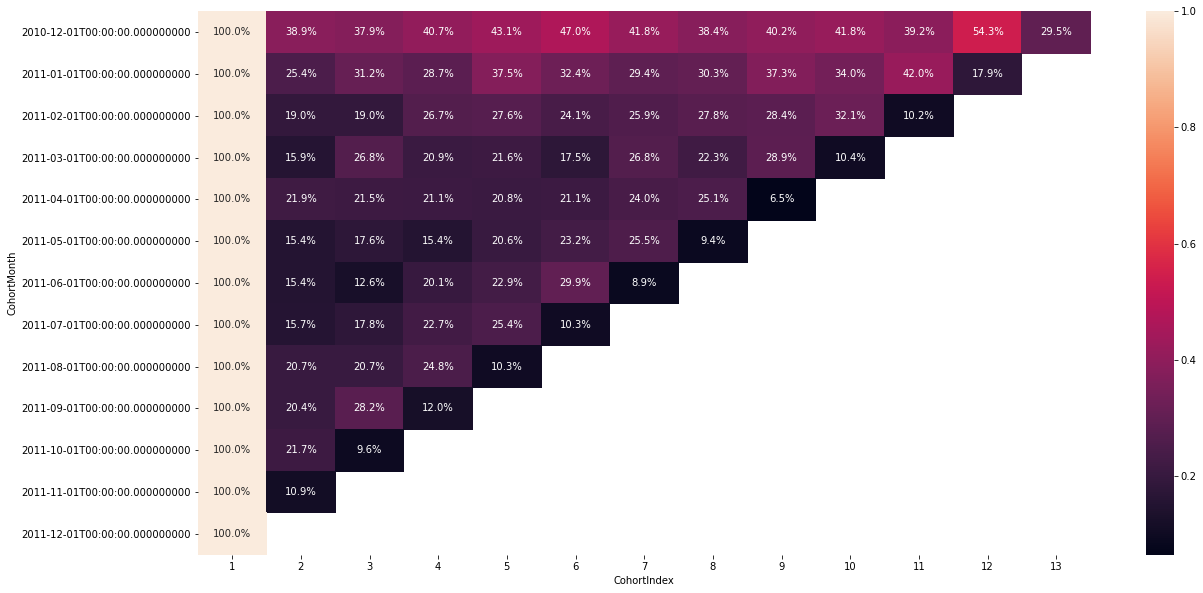

In [23]:
# 히트맵(Heat map)으로 시각화
fig = plt.figure(figsize = (20, 10))
sns.heatmap(retention_rate, annot = True, fmt = '.1%', cbar = True)

# 인사이트 도출
- 가설 확인
    * 코호트 그룹별 retention rate 증가와 감소를 반복하는 불규칙한 모습 보이며 '코호트 그룹간 retention rate의 유의미한 차이점이 존재한다'는 가설 거짓으로 확인
    * 이에 따라 코호트 분석 결과를 바탕으로, 사용자 인사이트 파악을 위한 추가 데이터 분석 방향 제안
- 추가 데이터 분석 방향 제안
    * 코호트 그룹간 규모의 차이 확인. 다른 데이터의 추가 분석을 통해 원인 파악 시도
        * 다른 연도 데이터와의 비교를 통해 월별 코호트의 차이가 매년 동일한 시즌성을 보이는지 확인
        * 마케팅 예산과의 비교를 통해 마케팅 화력 차이 때문인지 확인
    * 코호트 별 retention rate는 증가와 감소를 반복하는 불규칙함 보임. 
        * 소비자들의 구매 패턴이 장기적이며 빈번하지 않을 것으로 추정
        * 소비자별 / 제품 별 재구매 시점 확인